# Sensitivity Uncertainty vs. Record Length

This Notebook produces Fig.5, plotting the SIA Sensitivity to CO<sub>2</sub> or GMST Uncertainty in relation to the end year of the regression period / the record length.

## Import Libraries

In [ ]:
# General imports
import numpy as np
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Data handling
import pandas as pd
import xarray as xr

# Custom modules
import helper as hlp
import emulator_func as em
import emulator_func_gmst as em_gmst

from functions.custom_logger_functions import *

## Set Paths

In [2]:
basepath = "/Users/quraus001/Documents/Uni/Thesis/"
datapath = basepath + "data/"
plotpath = basepath + "Paper/endyear/"

save_plots = False

## Load Data

In [3]:
# observed CO2 data (Global Carbon Project)
df_co2 = pd.read_csv(datapath + "co2/CO2_historical_global-carbon-budget_cum.csv", index_col="Year") 

# sea-ice area (UHH-SIA)
file   = "SIA_observations_nh_v2025_fv0.01_nsidc_osisaf.nc" 
ds_sia = xr.open_dataset(datapath + file)
df_sia = ds_sia.sel(time=ds_sia['time'].dt.month == 9).to_dataframe() # select September data
df_sia.index = df_sia.index.year # convert datetime index to years
df_sia = df_sia.loc[1979:2024] # limit to satellite era
df_sia = df_sia.drop(columns=['nsidc_cdr'])

# GMST data (Berkeley Earth, GISSTEMPv4, NOAA, HadCRUT4)
df_gmst = pd.read_csv(f"{datapath}GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkeleyEarth-NOAA-HadCRUT4-Kadow.csv", 
                      comment="#", sep=",", skipinitialspace=True, 
                      names=["Year", "BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow", "NOAA_rebased", "HadCRUT4_rebased", "Kadow_rebased"])
df_gmst.set_index("Year", inplace=True)  # convert time index to years
df_gmst

,BerkeleyEarth,GISSTEMPv4,NOAA,HadCRUT4,Kadow,NOAA_rebased,HadCRUT4_rebased,Kadow_rebased
Year,,,,,,,,
1850,NaN,-0.436,-0.496959,-0.417711,-0.460125,-0.220257,-0.341109,-0.375673
1851,NaN,-0.321,-0.390814,-0.233350,-0.439743,-0.114113,-0.156747,-0.355290
1852,NaN,-0.292,-0.352384,-0.229399,-0.337969,-0.075682,-0.152797,-0.253516
1853,NaN,-0.295,-0.407147,-0.270354,-0.394087,-0.130445,-0.193752,-0.309635
1854,NaN,-0.283,-0.367742,-0.291521,-0.403480,-0.091040,-0.214919,-0.319028
...,...,...,...,...,...,...,...,...
2020,1.01,1.049,0.711575,0.922921,0.903198,0.988277,0.999523,0.987651
2021,0.85,0.895,0.559328,0.761906,0.739998,0.836029,0.838508,0.824451
2022,0.89,0.936,0.591291,0.801305,0.793924,0.867992,0.877908,0.878376


## Main Loop

In [19]:
logLevel = "error"
runs = 100000

end_years = np.arange(1995, 2025, 5)
end_years = np.append(end_years, [2024])

params = {"member": "osisaf",
           "df_co2": df_co2,
           "df_sia": df_sia,
           "runs": runs,
           "noise_type": "ar1",
           "observation_start": 1979,
           "observation_end": 2024,
           "true_slope": None,
           "amplitude": None,
           "ar1_corrcoef": None,
           "co2_name": "both_cum",
           "sigma_correction": True,
           "phi_correction": True}

logger = build_terminal_logger(logLevel, "endyear_experiment")

# Storage for results
Means, STD1, STD2 = [], [], []
Means_gmst, STD1_gmst, STD2_gmst = [], [], []

# Products to analyze
products = ["osisaf", "nsidc_bt", "nsidc_nt"]
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

# Helper functions to collect statistics
def collect_stats(vals):
    arr = np.asarray(vals, float)
    mu, s1 = arr.mean(), arr.std()
    return float(mu), float(s1), float(2*s1)

def stats_to_array(Means, STD1, STD2):
    Means = np.array(Means)
    STD1  = np.array(STD1)
    STD2  = np.array(STD2)  
    return Means, STD1, STD2

# Main loop over end years
for end_year in tqdm(end_years[:]):
    logger.info(f"\nEnd year: {end_year}")
    logger.debug(f"Record length: {end_year - 1979 +1}")
    params["observation_end"]   = end_year

    SENS = []
    SENS_gmst = []
    #gmst_products = ["BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow"]
    for product in products[:]:
        logger.debug(product)
        params["member"] = product
        Sensitivities, obs_sens, emulator_sia = em.experiment(**params)
        SENS += Sensitivities

        for gmst_product in gmst_products[:]:
            logger.debug(f"  with GMST: {gmst_product}")
            params_gmst = params.copy()
            params_gmst["df_co2"] = df_gmst
            params_gmst["co2_name"] = gmst_product
            params_gmst["runs"] = int(runs/len(products))
            Sensitivities_gmst, obs_sens_gmst, emulator_sia_gmst = em_gmst.experiment(**params_gmst)
            SENS_gmst += Sensitivities_gmst

    mu, s1, s2 = collect_stats(SENS)
    Means.append(mu); STD1.append(s1); STD2.append(s2)
    logger.debug(f"Sensitivity: {np.mean(SENS):1.2f} ± {np.std(SENS):1.2f} (1σ), ± {2*np.std(SENS):1.2f} (2σ)")

    mu_g, s1_g, s2_g = collect_stats(SENS_gmst)
    Means_gmst.append(mu_g); STD1_gmst.append(s1_g); STD2_gmst.append(s2_g)
    logger.debug(f"GMST Sensitivity: {np.mean(SENS_gmst):1.2f} ± {np.std(SENS_gmst):1.2f} (1σ), ± {2*np.std(SENS_gmst):1.2f} (2σ)")

# Convert to arrays
Means, STD1, STD2  = stats_to_array(Means, STD1, STD2)
Means_gmst, STD1_gmst, STD2_gmst = stats_to_array(Means_gmst, STD1_gmst, STD2_gmst)

 14%|█▍        | 1/7 [04:12<25:16, 252.77s/it]


KeyboardInterrupt: 

## Plotting

In [7]:
print(Means)
print(end_years)
print(STD2)

for i in range(len(end_years)):
    print(f"{end_years[i]}, {Means[i]:1.2f}, {STD2[i]:1.2f} ")

[-2.17685968 -2.00525001 -2.15163162 -2.69173935 -2.66753903 -2.49681965
 -2.24697598]
[1995 2000 2005 2010 2015 2020 2024]
[1.47734738 0.94436017 0.63522492 0.64991376 0.59276413 0.50282608
 0.48404323]
1995, -2.18, 1.48 
2000, -2.01, 0.94 
2005, -2.15, 0.64 
2010, -2.69, 0.65 
2015, -2.67, 0.59 
2020, -2.50, 0.50 
2024, -2.25, 0.48 


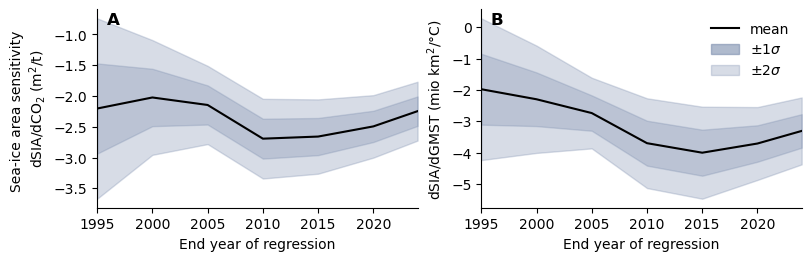

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2.5), constrained_layout=True)

ax1.plot(end_years, Means, color="black")
ax2.plot(end_years, Means_gmst, color="black")

color = "#7B8CAD" # "#00577d"
ax1.fill_between(end_years, Means - STD1, Means + STD1, alpha=0.3, color=color) ## "#00577d" "#7B8CAD"
ax2.fill_between(end_years, Means_gmst - STD1_gmst, Means_gmst + STD1_gmst, alpha=0.3, color=color)

ax1.fill_between(end_years, Means - STD2, Means + STD2, alpha=0.3, color=color)
ax2.fill_between(end_years, Means_gmst - STD2_gmst, Means_gmst + STD2_gmst, alpha=0.3, color=color)

for ax, letter in zip([ax1, ax2], ["A", "B"]):
    ax.margins(x=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("End year of regression")
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12)

ax1.set_ylabel("Sea-ice area sensitivity \ndSIA/dCO$_2$ (m$^2$/t)")
ax2.set_ylabel("dSIA/dGMST (mio km$^2$/°C)")

legend_elements = [Line2D([np.nan],[np.nan],color = "black", label = "mean", alpha=1),
                        Patch(color = color, label = r"$\pm1\sigma$", alpha=0.6),
                    Patch(color = color, label = r"$\pm2\sigma$", alpha=0.3)]

lgd = ax.legend(loc='upper right',handles = legend_elements, frameon=False)

#fig.subplots_adjust(wspace=0.2)
filename = "endyear_all_sub-obs_co2-gmst"
#hlp.save_plot(plotpath + filename, save_plots, ["png","pdf"], dpi=300)

In [ ]:
for product in 
def grab_parameters(member, df_co2, df_sia, observation_start, observation_end, amplitude=None, ar1_corrcoef=None, forcing="rcp85", sigma_correction=True, phi_correction=False):


In [ ]:
def grab_parameters(member, 
                    df_co2, 
                    df_sia, 
                    observation_start, 
                    observation_end, 
                    amplitude=None, 
                    ar1_corrcoef=None, 
                    forcing="rcp85", 
                    sigma_correction=True, 
                    phi_correction=False):


In [26]:
def build_dict():
    dictionary = {}
    for sia_product in ["osisaf", "nsidc_bt", "nsidc_nt"]:
        dictionary[sia_product] = {}
        for gmst_product in ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']:
            dictionary[sia_product][gmst_product] = []
    return dictionary

def build_dict2():
    dictionary = {}
    for sia_product in ["osisaf", "nsidc_bt", "nsidc_nt"]:
        dictionary[sia_product] = []
    return dictionary

In [43]:
import siametadata as meta


logLevel = "debug"
runs = 100000

end_years = np.arange(1995, 2025, 5)
end_years = np.append(end_years, [2024])

params = {"member": "osisaf",
           "df_co2": df_gmst,
           "df_sia": df_sia,
           "observation_start": 1979,
           "observation_end": 2024,
           "amplitude": None,
           "ar1_corrcoef": None,
           "forcing": "both_cum",
           "sigma_correction": False,
           "phi_correction": True}

logger = build_terminal_logger(logLevel, "endyear_experiment")


# Products to analyze
products = ["osisaf", "nsidc_bt", "nsidc_nt"]
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

sigma_gmst = build_dict()
phi_gmst = build_dict()
sens_gmst = build_dict()
r2_gmst = build_dict()
sigma = build_dict2()
phi = build_dict2()
sens = build_dict2()
r2 = build_dict2()


# Main loop over end years
for end_year in tqdm(end_years[:]):
    logger.info(f"\nEnd year: {end_year}")
    logger.debug(f"Record length: {end_year - 1979 +1}")
    params["observation_end"]   = end_year


    #gmst_products = ["BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow"]
    for product in products[:]:
        logger.debug(product)
        params["member"] = product
        params["df_co2"] = df_co2
        params["forcing"] = "both_cum"
        obs_sens, amplitude, ar1_corrcoef = em.grab_parameters(**params)
        sigma[product].append(amplitude)
        phi[product].append(ar1_corrcoef)
        sens[product].append(obs_sens)

        co2 = df_co2.loc[1979:end_year]["both_cum"]
        sia = df_sia.loc[1979:end_year][product]
        r2[product].append((np.corrcoef(co2,sia)[0,1]**2).item())

        for gmst_product in gmst_products[:]:
            logger.debug(f"  with GMST: {gmst_product}")
            params["df_co2"] = df_gmst
            params["forcing"] = gmst_product
            obs_sens, amplitude, ar1_corrcoef = em_gmst.grab_parameters(**params)

            sigma_gmst[product][gmst_product].append(amplitude)
            phi_gmst[product][gmst_product].append(ar1_corrcoef)
            sens_gmst[product][gmst_product].append(obs_sens)

            gmst = df_gmst.loc[1979:end_year][gmst_product]
            r2_gmst[product][gmst_product].append((np.corrcoef(co2,gmst)[0,1]**2).item())

            logger.debug(f"{obs_sens}, {amplitude}, {ar1_corrcoef}")
    

  0%|          | 0/7 [00:00<?, ?it/s]
End year: 1995
Record length: 17
osisaf
  with GMST: BerkeleyEarth
-2.1163092337443437, 0.41710041130568754, 0.23378480435406776
  with GMST: GISSTEMPv4
-2.0795920523710363, 0.41317279324070105, 0.26297022032322065
  with GMST: NOAA_rebased
-2.1250243600777097, 0.42515447313706645, 0.31000804460523956
  with GMST: HadCRUT4_rebased
-2.018638169997596, 0.41978994398180647, 0.2763250590927132
  with GMST: Kadow_rebased
-2.113809649573376, 0.413114540898566, 0.23006095994790232
nsidc_bt
  with GMST: BerkeleyEarth
-2.000698627895234, 0.4110870914289234, 0.15793719142378604
  with GMST: GISSTEMPv4
-2.1086352154241137, 0.3989508910419112, 0.15047374877508274
  with GMST: NOAA_rebased
-2.0777841739515193, 0.4153008095541848, 0.21098506447259477
  with GMST: HadCRUT4_rebased
-2.05496912775293, 0.4055271009378104, 0.17340811507597967
  with GMST: Kadow_rebased
-2.1242353567032524, 0.400064682447245, 0.13679415690375094
nsidc_nt
  with GMST: BerkeleyEarth
-1.

In [41]:
r2

{'osisaf': [0.4050530272988307,
  0.49797249158337775,
  0.6578552746730941,
  0.778843710197487,
  0.809163568029518,
  0.8430770343307024,
  0.8262857908661135],
 'nsidc_bt': [0.3767521027880915,
  0.44546833000573804,
  0.6451763922158749,
  0.7651321994902317,
  0.8012772198394116,
  0.8408725459996662,
  0.8311917055617949],
 'nsidc_nt': [0.3850918435040523,
  0.4542652526267919,
  0.6310226735557165,
  0.7643546111856038,
  0.7998413772092873,
  0.8386643655437385,
  0.8346207245795945]}

In [14]:
sigma[product]#[gmst_product]

{'BerkeleyEarth': [np.float64(0.3986173791623568)],
 'GISSTEMPv4': [np.float64(0.3986173791623568)],
 'NOAA_rebased': [],
 'HadCRUT4_rebased': [],
 'Kadow_rebased': []}

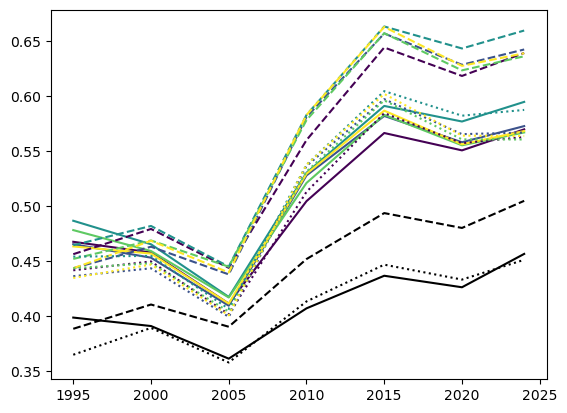

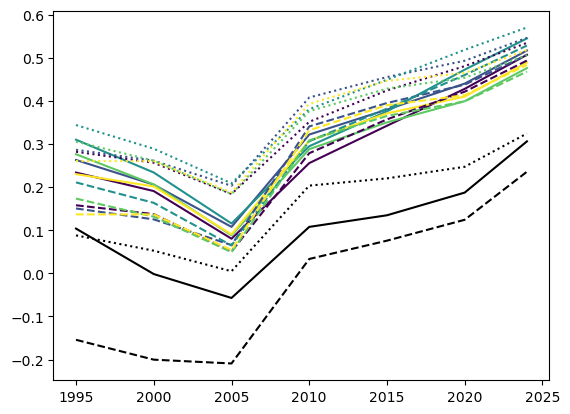

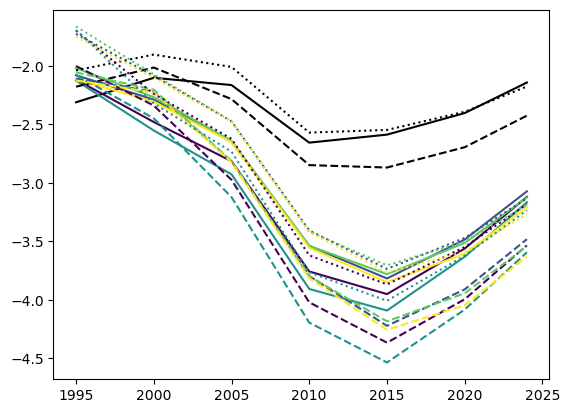

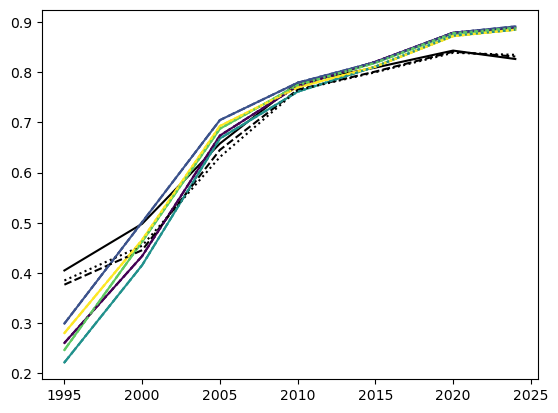

In [42]:
linestyles = ["-", "--",":"]

# Choose a colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
import matplotlib.colors as mcolors
hex_colors = [mcolors.to_hex(c) for c in colors]

for dictionary, dictionary_gmst in zip([sigma, phi, sens, r2], [sigma_gmst, phi_gmst, sens_gmst, r2_gmst]):
    fig, ax = plt.subplots()
    for i, sia_product in enumerate(["osisaf", "nsidc_bt", "nsidc_nt"]):
            ax.plot(end_years, dictionary[sia_product], linestyle=linestyles[i], color="black")
            for j, gmst_product in enumerate(['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']):
                ax.plot(end_years, dictionary_gmst[sia_product][gmst_product], linestyle=linestyles[i], color=hex_colors[j])



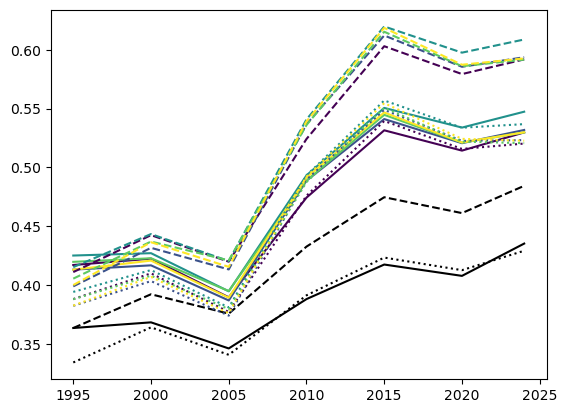

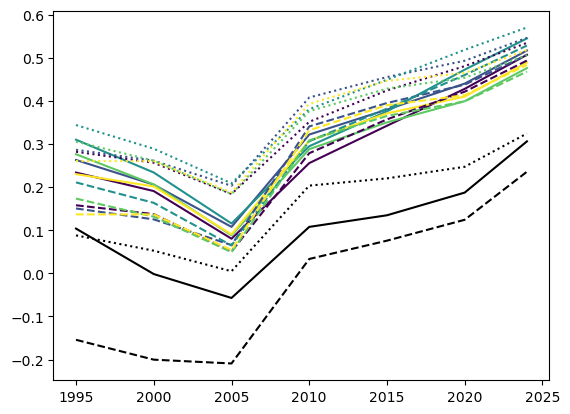

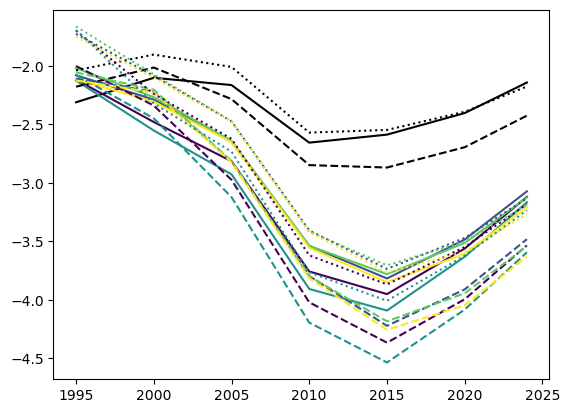

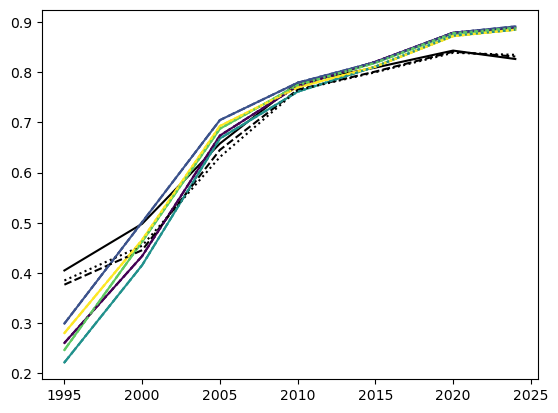

In [44]:
linestyles = ["-", "--",":"]

# Choose a colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
import matplotlib.colors as mcolors
hex_colors = [mcolors.to_hex(c) for c in colors]

for dictionary, dictionary_gmst in zip([sigma, phi, sens, r2], [sigma_gmst, phi_gmst, sens_gmst, r2_gmst]):
    fig, ax = plt.subplots()
    for i, sia_product in enumerate(["osisaf", "nsidc_bt", "nsidc_nt"]):
            ax.plot(end_years, dictionary[sia_product], linestyle=linestyles[i], color="black")
            for j, gmst_product in enumerate(['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']):
                ax.plot(end_years, dictionary_gmst[sia_product][gmst_product], linestyle=linestyles[i], color=hex_colors[j])



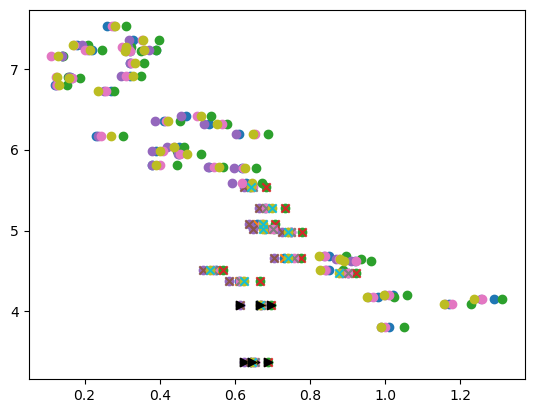

In [ ]:
for gmst_product in gmst_products:
    
    plt.scatter(df_gmst[gmst_product].loc[1979:2024], df_sia["nsidc_bt"].loc[1979:2024])
    plt.scatter(df_gmst[gmst_product].loc[2005:2015], df_sia["nsidc_bt"].loc[2005:2015], marker="x")
    plt.scatter(df_gmst[gmst_product].loc[2012], df_sia["nsidc_bt"].loc[2012], marker=">", color="black")
    plt.scatter(df_gmst[gmst_product].loc[2007], df_sia["nsidc_bt"].loc[2007], marker=">", color="black")

In [59]:
for i in range(-3,1):
    print(i)

-3
-2
-1
0


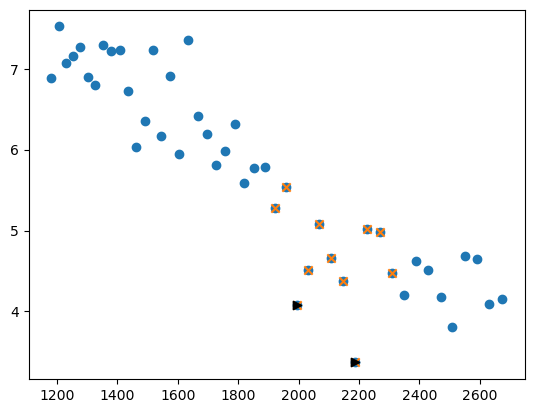

In [54]:
plt.scatter(df_co2["both_cum"].loc[1979:2024], df_sia["nsidc_bt"].loc[1979:2024])
plt.scatter(df_co2["both_cum"].loc[2005:2015], df_sia["nsidc_bt"].loc[2005:2015], marker="x")
plt.scatter(df_co2["both_cum"].loc[2012], df_sia["nsidc_bt"].loc[2012], marker=">", color="black")
plt.scatter(df_co2["both_cum"].loc[2007], df_sia["nsidc_bt"].loc[2007], marker=">", color="black")

In [60]:
import siametadata_gmst as meta_gmst

In [61]:
help(meta_gmst)


Help on module siametadata_gmst:

NAME
    siametadata_gmst - # calculate meta data

FUNCTIONS
    find_icefree_idx(sia, amount_icefree=1, threshold_value=1, printing=True)
        Find the index of the first occurrence of ice-free conditions in a sea-ice area (SIA) array.
        
        This function searches for the index where the sea ice area falls below a specified threshold,
        indicating ice-free conditions. It can be configured to find the nth occurrence of ice-free conditions.
        
        Parameters:
        -----------
        sia : array-like
            An array of sea ice area values.
        amount_icefree : int, optional
            The nth occurrence of ice-free conditions to find (default is 1, i.e., the first occurrence).
        threshold_value : float, optional
            The threshold value below which the sea ice area is considered ice-free (default is 1).
        
        Returns:
        --------
        int or False
            The index of the nth

In [72]:
from scipy.stats import linregress


def get_residuals(y):
    result = linregress(np.arange(len(y)), y)
    y_pred     = result.intercept + result.slope*np.arange(len(y))
    return y-y_pred

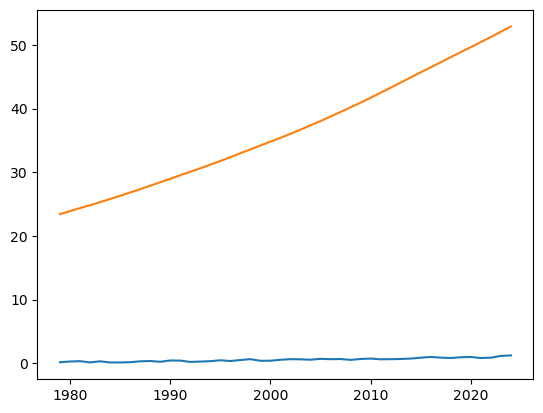

In [73]:
y = df_gmst[gmst_product].loc[1979:2024]
result = linregress(np.arange(len(y)), y)
y_pred     = result.intercept + result.slope*co2
plt.plot(y)
plt.plot(y_pred)

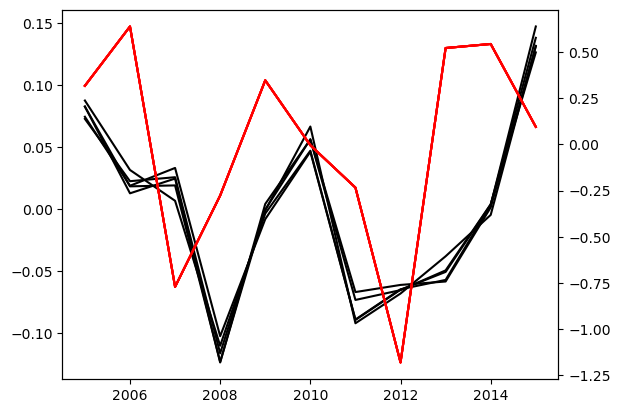

In [78]:
fig, ax = plt.subplots(1)
ax_twin = ax.twinx()
for gmst_product in gmst_products:
    ax.plot(get_residuals(df_gmst[gmst_product].loc[2005:2015]), color="black")
    ax_twin.plot(get_residuals(df_sia["nsidc_bt"].loc[2005:2015]), color="red")

In [80]:
get_residuals(df_sia["nsidc_bt"].loc[2005:2015])

time
2005    0.318117
2006    0.639760
2007   -0.771952
2008   -0.276823
2009    0.347814
2010   -0.004339
2011   -0.233910
2012   -1.182005
2013    0.522983
2014    0.544865
2015    0.095490
Name: nsidc_bt, dtype: float64

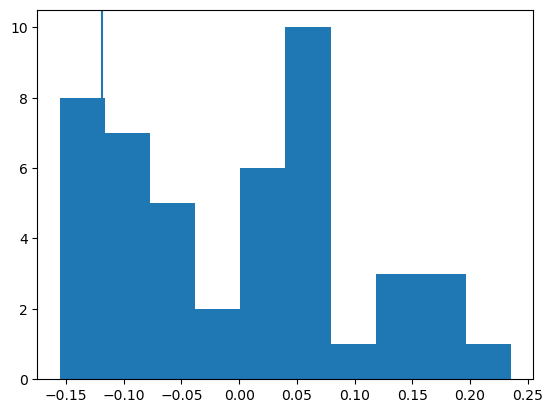

In [81]:
plt.hist(get_residuals(df_gmst[gmst_product].loc[1979:2024]))
plt.axvline(get_residuals(df_gmst[gmst_product].loc[1979:2024]).loc[2012])

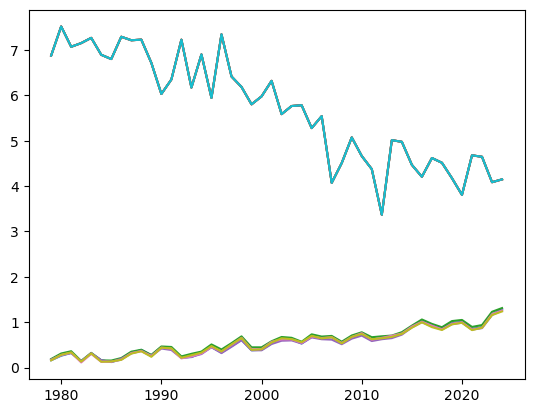

In [ ]:

for gmst_product in gmst_products:
    
    plt.plot(df_gmst[gmst_product].loc[1979:2024])
    plt.plot(df_sia["nsidc_bt"].loc[1979:2024])
